# Reconstrucción de la señal de difusión con el modelo tensorial (DTI)

El modelo del tensor de difusión describe a la señal como:
$$
\mathbf{S}(\mathbf{g},b) = S_0\text{e}^{ -b \mathbf{g}^T\mathbf{D}\mathbf{g} }
$$
donde $\mathbf{g}$ es la dirección gradiente con valor asociado $b$, $\mathbf{S}(\mathbf{g},b)$ es la señal obtenida con dichos parámetros, $S_0$ es la señal de referencia  y $\mathbf{D}$ es el tensor de difusión.

Tenemos entonces 6 parámetros para ajustar, por la simetría de $\mathbf{D}$:
$$
\mathbf{D} = \begin{pmatrix} D_{xx} & D_{xy} & D_{xz} \\
                       D_{yx} & D_{yy} & D_{yz} \\
                       D_{zx} & D_{zy} & D_{zz} \\ \end{pmatrix}
$$

Importamos algunas librerías junto con un conjunto de datos:

In [14]:
import numpy as np
import nibabel as nib
import dipy.reconst.dti as dti # reconstruction algorithms
from dipy.data import fetch_stanford_hardi # small datasets
fetch_stanford_hardi() # Download a HARDI dataset with 160 gradient directions

Dataset is already in place. If you want to fetch it again please first remove the folder /home/david/.dipy/stanford_hardi 


({'HARDI150.bval': ('https://stacks.stanford.edu/file/druid:yx282xq2090/dwi.bvals',
   '4e08ee9e2b1d2ec3fddb68c70ae23c36'),
  'HARDI150.bvec': ('https://stacks.stanford.edu/file/druid:yx282xq2090/dwi.bvecs',
   '4c63a586f29afc6a48a5809524a76cb4'),
  'HARDI150.nii.gz': ('https://stacks.stanford.edu/file/druid:yx282xq2090/dwi.nii.gz',
   '0b18513b46132b4d1051ed3364f2acbc')},
 '/home/david/.dipy/stanford_hardi')

Y lo leemos:

In [15]:
from dipy.data import read_stanford_hardi
img, gtab = read_stanford_hardi()

Dataset is already in place. If you want to fetch it again please first remove the folder /home/david/.dipy/stanford_hardi 


`img` es un objeto `Nifti1Image` de `nibabel` y `gtab` es un objeto `GradientTable` de `DiPy`.

In [16]:
data = img.get_data()
print('data.shape (%d, %d, %d, %d)' % data.shape)

data.shape (81, 106, 76, 160)


Primero, creamos una máscara para nuestros datos:

In [17]:
from dipy.segment.mask import median_otsu
maskdata, mask = median_otsu(data, 3, 1, True,
                             vol_idx=range(10, 50), dilate=2) # (masked_data, mask)
print('maskdata.shape (%d, %d, %d, %d)' % maskdata.shape)

maskdata.shape (71, 87, 62, 160)


Para realizar el ajuste, inicializamos el modelo y llamamos al método `fit`:

In [18]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(maskdata)

El método `fit` crea un objeto `TensorFit` con los parámetros de ajuste y otros atributos del modelo; por ejemplo, la *Anisotropía Fraccional* (FA), definida como:
$$
FA = \sqrt{\frac{1}{2}\frac{(\lambda_1-\lambda_2)^2+(\lambda_1-
                    \lambda_3)^2+(\lambda_2-\lambda_3)^2}{\lambda_1^2+
                    \lambda_2^2+\lambda_3^2}}
$$
donde $\lambda_1\ge\lambda_2\ge\lambda_3$ son los valores propios de $\mathbf{D}$.

In [19]:
from dipy.reconst.dti import fractional_anisotropy, color_fa
FA = fractional_anisotropy(tenfit.evals)
FA[np.isnan(FA)] = 0

Podemos visualizar cualquier rebanada fácilmente:

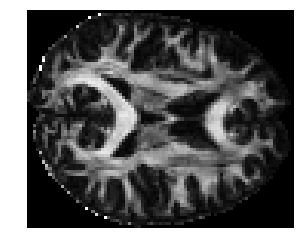

In [20]:
import matplotlib.pyplot as plt
plt.imshow(FA[:,:,30],cmap='gray')
plt.gca().set_axis_off()
plt.show()

Y guardar la imagen, sus valores propios ó vectores propios, en formato Nifti:

In [21]:
fa_img = nib.Nifti1Image(FA.astype(np.float32), img.affine)
#nib.save(fa_img, 'tensor_fa.nii.gz')
evecs_img = nib.Nifti1Image(tenfit.evecs.astype(np.float32), img.affine)
#nib.save(evecs_img, 'tensor_evecs.nii.gz')
evals_img = nib.Nifti1Image(tenfit.evals.astype(np.float32), img.affine)
#nib.save(evals_img, 'tensor_evals.nii.gz')

Otra estadística de este modelo es la *difusión media* (MD); podemos calcularla de dos formas:

In [22]:
MD1 = dti.mean_diffusivity(tenfit.evals)
#nib.save(nib.Nifti1Image(MD1.astype(np.float32), img.affine), 'tensors_md.nii.gz')

In [23]:
MD2 = tenfit.md

Y resultan equivalentes:

In [24]:
np.linalg.norm(MD1-MD2)

0.0

Para graficar el mapeo a color de la FA evaluamos:

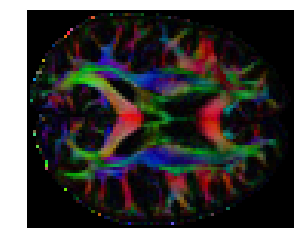

In [25]:
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs) # Color fractional anisotropy of diffusion tensor
#nib.save(nib.Nifti1Image(np.array(255 * RGB, 'uint8'), img.affine), 'tensor_rgb.nii.gz')
plt.imshow(RGB[:,:,31,:]) # Slice 31
plt.gca().set_axis_off()
plt.show()

Calculamos los elipsoides de difusión de un área rectangular de nuestra imágen (cuerpo calloso).

In [26]:
from dipy.data import get_sphere
sphere = get_sphere('symmetric724')

In [28]:
from dipy.viz import window, actor

In [41]:
interactive = True
ren = window.Renderer()

evals = tenfit.evals[13:43, 44:74, 28:29]
evecs = tenfit.evecs[13:43, 44:74, 28:29]

Seleccionamos un área de interés (ROI):

In [44]:
cfa = RGB[13:43, 44:74, 28:29] # ROI
cfa /= cfa.max() # values normalized to increase the contrast.

ren.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere, scale=0.3))

print('Saving illustration as tensor_ellipsoids.png')
window.record(ren, n_frames=1, out_path='tensor_ellipsoids.png', size=(900, 900))
if interactive:
    window.show(ren)

Saving illustration as tensor_ellipsoids.png


Visualizamos la imagen:

![](tensor_ellipsoids.png)

In [38]:
window.clear(ren)

Para visualizar las funciones de distribución de orientaciones (ODFs) de la misma área:

In [45]:
tensor_odfs = tenmodel.fit(data[20:50, 55:85, 38:39]).odf(sphere)

odf_actor = actor.odf_slicer(tensor_odfs, sphere=sphere, scale=0.5, colormap=None)
ren.add(odf_actor)
print('Saving illustration as tensor_odfs.png')
window.record(ren, n_frames=1, out_path='tensor_odfs.png', size=(600, 600))
if interactive:
    window.show(ren)

Saving illustration as tensor_odfs.png


Visualizamos la imagen:

![](tensor_odfs.png)

Una desventaja del modelo DTI es que sólo tiene una dirección de fibra principal, por lo que presenta problemas en zonas donde hay fibras cruzadas ó tangentes.